### Примеры работы пайплайна для создания вейвлет-скалограмм и пайплайна для генерации фич из Stationary Wavelet Transform.

Повторение preprocessing-stage из этой статьи[https://sci-hub.se/10.1016/j.irbm.2019.09.003]:
"The ECG signal from PTB-Database is down sampled to a sampling frequency f s = 250 Hz, since most of the obligatory information is covered in this range. The down sampled ECG signal is segmented into short ECG segments of 3.072 seconds. The downsampled and segmented signal is passed through a 2-stage median filter to remove the baseline wander. This is followed by a Savitzky-Golay (SG) smoothing filter. Window width of the two stages of median filter and SG filter’s order and frame size is selected as described in [34–36]. Say, ECG signal after this preprocessing stage be z[n]."

In [9]:
import pandas as pd
import numpy as np

gts_df = pd.read_csv("./train/train_gts.csv")
meta_df = pd.read_csv("./train/train_meta.csv")

df = pd.merge(gts_df, meta_df, on='record_name')

In [10]:
import os
import  matplotlib.pyplot as plt


def load_record(record_name, prefix):
    path = os.path.join(prefix, record_name + ".npy")    
    record = np.load(path)
    return record

def print_record(x, y, name):
    plt.figure(figsize=(16, 8))
    plt.plot(x, y)
    plt.title(name)
    plt.xlabel("Time")

Downsampling
оригинальная дата - 500 hz
в статье предлагают 250 hz

In [11]:
from scipy.signal import decimate 
from scipy.signal import medfilt 
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
import pywt

def downsample(record):
    # downsample from 500 to 250 hz
    return decimate(record, 2) 

Разделить на сегменты
3.072 секунды, потому что нужно, чтобы было 768 элементов в сегменте для работы stationary wavelet transform

In [12]:
meow = downsample(load_record("00009_hr", './train/'))
def segmentation(record, hz=250, segment_time=3.072):
    """
        hz -  герц у сигнала
        segment_time - количество секунд в сегменте
        record.shape = [12,2500]
    """
    # так как 2500 не делится на 768 укорачиваю последнюю axis, так чтобы делилось.
    segment_len = int(hz*segment_time)
    chuncks_num = len(record[0])//segment_len
    record = record[:,:int(chuncks_num*segment_len)]

    result = np.asarray(np.split(record,chuncks_num, axis=-1))
    result = np.reshape(result, (12, result.shape[0], result.shape[-1])) # by default shape is 12,3,768
    return result


### Наглядный примеры удаления шума из сигнала.

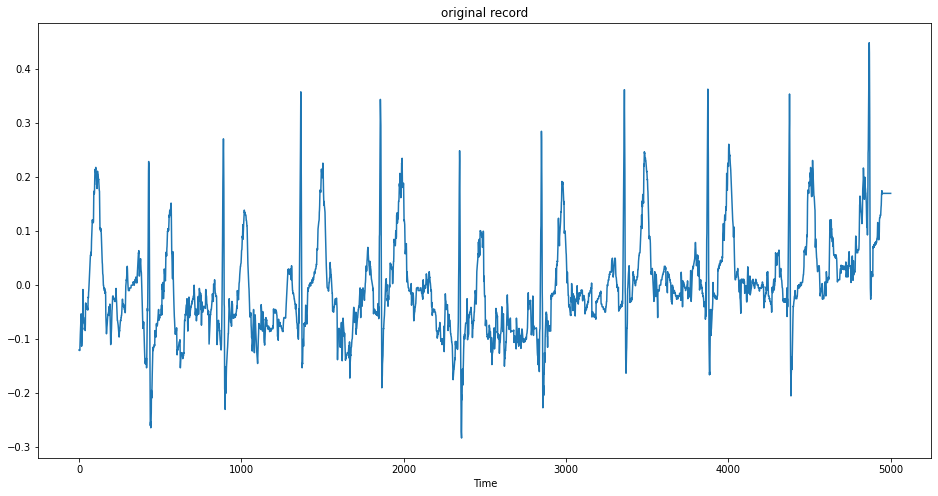

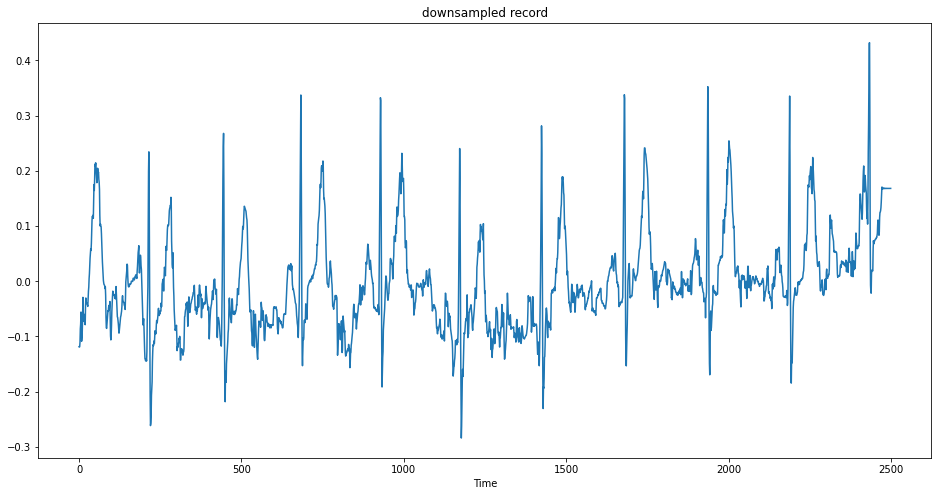

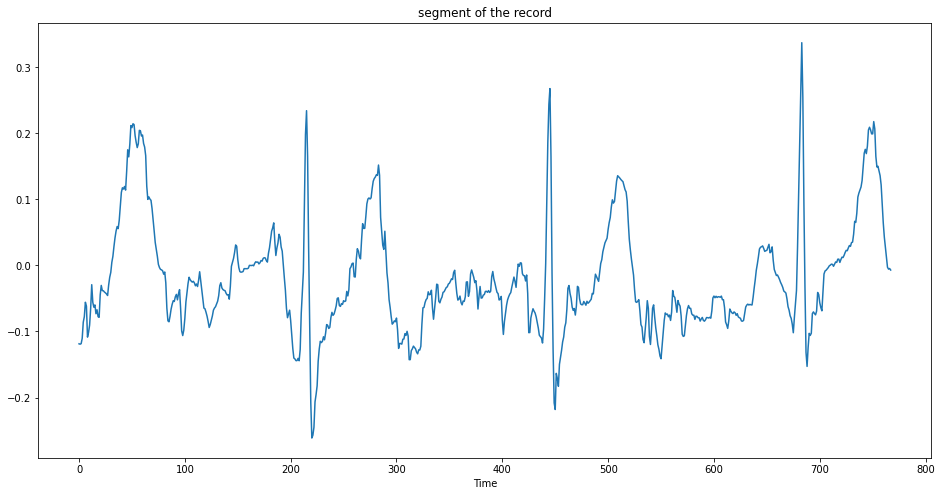

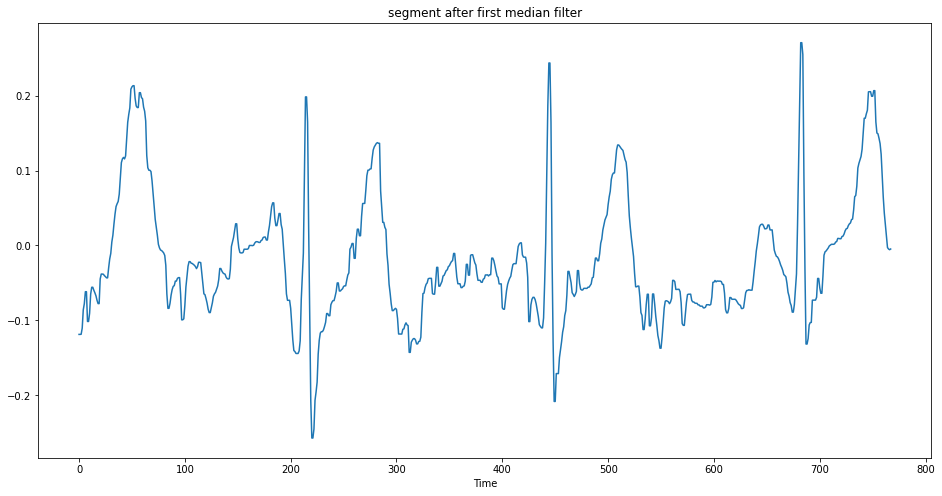

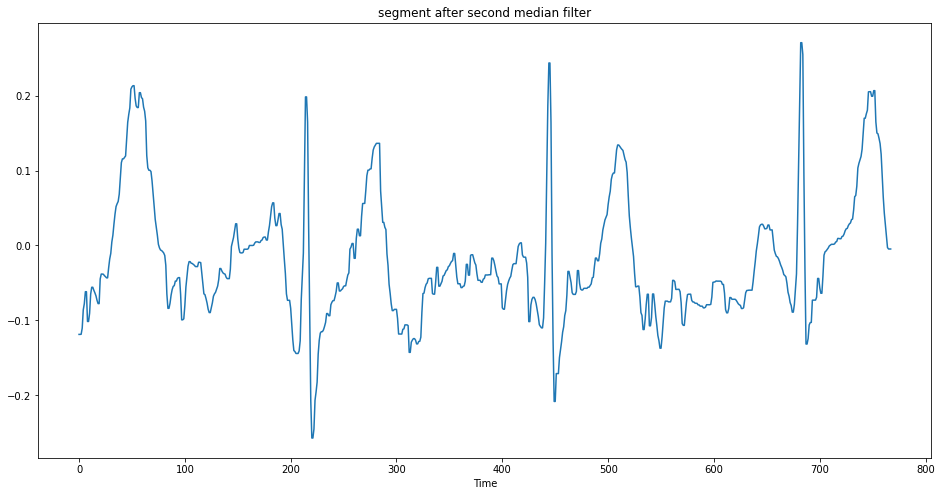

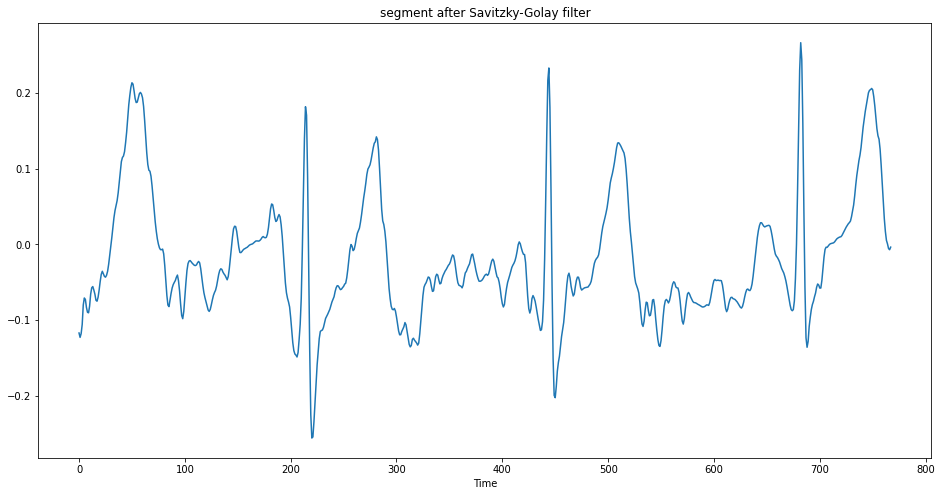

In [13]:
test_record = load_record("00009_hr", './train/')
print_record([x for x in range(len(test_record[0]))], test_record[0], name="original record")
test_record = downsample(test_record)
print_record([x for x in range(len(test_record[0]))], test_record[0], name="downsampled record")
test_record = segmentation(test_record)
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0], name="segment of the record")


test_record = medfilt(test_record,kernel_size=[1,1,3])
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0], name="segment after first median filter")

test_record = medfilt(test_record,kernel_size=[1,1,3])
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0], name="segment after second median filter")


test_record = savgol_filter(test_record, window_length = 8, polyorder=3)
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0], name="segment after Savitzky-Golay filter")


In [14]:
# 6 - количество уровней(каждый уровень типа разное приближение); 2 - [coeficients, frequencies]; 12,3,768 - 12 экг каналов поделенные на 3 сегмента по 768
test_record = np.asarray(pywt.swt(test_record, wavelet='db5', level=6, axis=-1))
test_record.shape 

(6, 2, 12, 3, 768)

### Пример работы пайплайна для генерации вейвлет-скалограмм.

 Вейвлет-скалограмма — это двумерное представление одномерных данных. На ось X наносится время, а на ось Y — шкала – результат вейвлет — преобразования сигнала соответствующее значению амплитуды сигнала в момент времени X. Такое преобразование, даёт дополнительную информацию о динамических свойствах сигнала.  Аналитическое значение такого графического отображения сигнала состоит в том, что разрешение по времени отображается на оси Y, что даёт дополнительную информацию о динамических свойствах сигнала. 

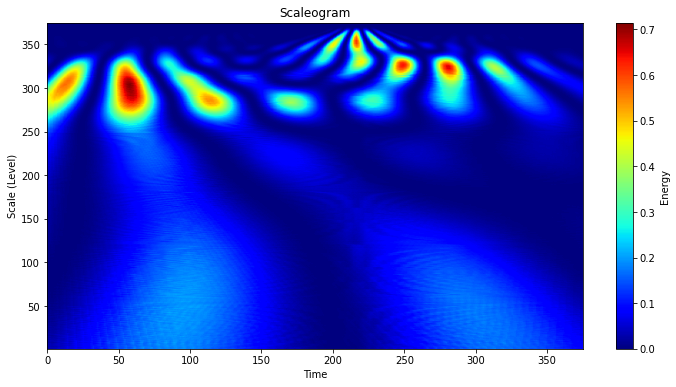

In [15]:
from preprocessing_CWT_DWT import Pipeline_CWT_CNN
pipeline = Pipeline_CWT_CNN(prefix="./train/", segment_num=1)
result = pipeline.run_pipeline("00009_hr", test=True)